In [1]:
import numpy as np
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt
import cmath
from scipy.special import lpmn, legendre
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from matplotlib.colors import LogNorm
import quasiclassical_solver as qs


from legendre import *

In [2]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456

# Simulation

In [44]:
solv = qs.Quasi_classic( m_rot = 110 * 1822.8884, 
                        Be_rot = 5614 * 1.5198298460570 * 1e-10, 
                        m_proj = 20 * 1822.8884 
                        )

solv.set_potential( lambda r, th: 
                   potential( r, th, 
                             C_12 = 2.5e7, 
                             alpha = 27.6 / au2A**3, 
                             mu = 2.38 * Db2au 
                            ) 
                    )
# solv.set_force( lambda r, th: force_field( r, th, C_12, alpha, mu )[0] )

j_init_arr = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

t_arr = []
alig_arr = []
r_arr = []
p_arr = []

t_eval = np.linspace( 0, 10 / au2ps, 1000 )

for l in j_init_arr:

    solv.set_hilbert_space( max_l=50, max_m = l )

    solv.set_initial_conditions( E_col = 0.5 / au2eV, r_0 = 50.0, l_0 = l )

    solv.solve( t_max = 10 / au2ps, t_arr = t_eval )

    # plt.plot( solv.t*au2ps, solv.alignment, label = f"j = {l}" )
    t_arr.append( solv.t )
    alig_arr.append( solv.alignment )
    r_arr.append( solv.r )
    p_arr.append( solv.p )

    print( f"j_init={l} finished" )

pass

j_init=0 finished
j_init=1 finished
j_init=2 finished
j_init=3 finished
j_init=4 finished
j_init=5 finished
j_init=6 finished
j_init=7 finished
j_init=8 finished
j_init=9 finished
j_init=10 finished


# Plotting

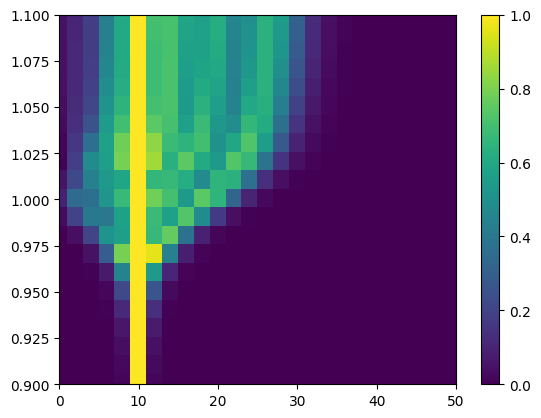

In [18]:
# t_0 = solv.t
# Psi_0 = solv.Psi

# t_gr, n_gr = np.meshgrid()

j_init = 10

l_max = np.max( solv.l_arr )
rot_prob = np.zeros( (solv.N_t, l_max + 1) )

for i, l in enumerate( solv.l_arr ):
    rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2

rot_prob = rot_prob / np.reshape( np.max( rot_prob, axis=1 ), (-1,1) )

plt.pcolor(np.arange( j_init%2, l_max + 1, 2 ), 
           solv.t*au2ps,
           rot_prob[:, j_init%2::2] )

plt.colorbar()

plt.xlim( 0, 50 )

plt.ylim( 0.9, 1.1 )

pass

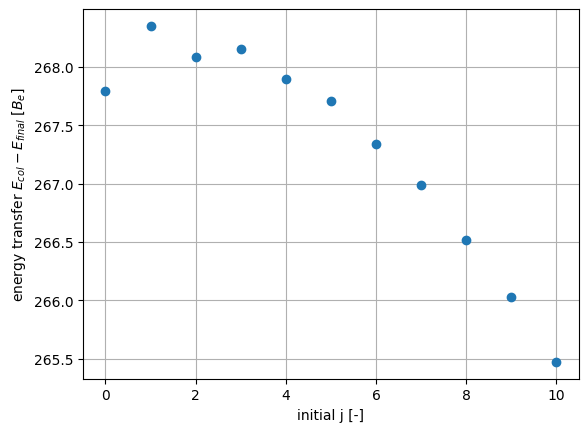

In [52]:
final_p = np.array([ p[-1] for p in p_arr ])
final_E = final_p**2 / 2 / solv.m_eff
E_col = solv.p_0**2 / 2 / solv.m_eff

plt.plot( j_init_arr, (E_col - final_E )/solv.Be_rot, 'o' )

plt.ylabel( r"energy transfer $E_{col} - E_{final}$ [$B_e$]" )
plt.xlabel( "initial j [-]" )

plt.grid()

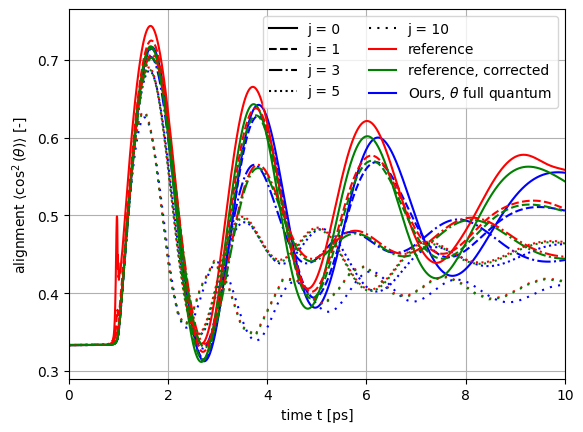

In [21]:

linestyle_arr = [ "solid", "dashed", "dashdot", "dotted", (0,(1,3)) ]

j_arr = [0, 1, 3, 5, 10]

al_av_arr = []
al_max_arr = []
al_min_arr = []

for t, alig, lnst in zip( t_arr, alig_arr, linestyle_arr ):
    plt.plot( t*au2ps, alig, "b", linestyle = lnst, markersize = 1 )

for j,lnst in zip(j_arr, linestyle_arr):
    data = loadmat( f"../data/wrong_alignment_j_{j}.m" )

    t_al = np.reshape( data["t"], (-1) )
    alig = np.reshape( data["allignment"], (-1) )

    plt.plot( t_al * au2ps, alig, "r", linestyle = lnst, markersize = 0.5 )

    
    data = loadmat( f"../data/corrected_alignment_j_{j}.m" )

    t_al = np.reshape( data["t"], (-1) )
    alig = np.reshape( data["allignment"], (-1) )

    plt.plot( t_al * au2ps, alig, "g", linestyle = lnst, markersize = 1 )


    i_0 = np.where( t_al * au2ps>2. )[0][0]

    av_val = np.sum( ( alig[i_0+1:] + alig[i_0:-1] ) / 2 * np.diff( t_al[i_0:] ) ) / ( t_al[-1] - t_al[i_0] )

    al_av_arr.append( av_val )
    al_max_arr.append( np.max(alig) )
    al_min_arr.append( np.min(alig) )

    plt.plot( [-1,-1], [0.5,0.5], "k", linestyle = lnst, label = f"j = {j}" )

plt.plot( [-1,-1], [0.5,0.5], 'r', label = "reference" )
plt.plot( [-1,-1], [0.5,0.5], 'g', label = "reference, corrected" )
plt.plot( [-1,-1], [0.5,0.5], 'b', label = r"Ours, $\theta$ full quantum " )

plt.xlim( 0, 10 )

# plt.xlim( 0.9, 1.1 )
# plt.ylim( 0.3, 0.55 )

plt.xlabel( "time t [ps]" )
plt.ylabel( r"alignment $\left< \cos^2(\theta) \right>$ [-]" )

plt.grid()
plt.legend( ncols = 2)
# plt.savefig("j_dependence_alignment_consistency.pdf")

pass

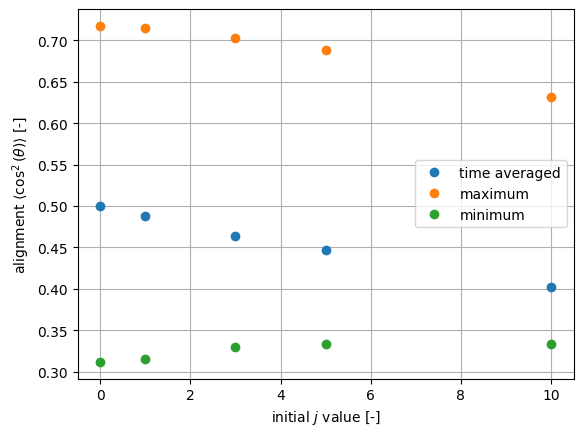

In [20]:
plt.plot( j_arr, al_av_arr, 'o', label = "time averaged" )
plt.plot( j_arr, al_max_arr, 'o', label = "maximum" )
plt.plot( j_arr, al_min_arr, 'o', label = "minimum"  )

# plt.ylim( 0.333333, 0.55 )

plt.legend()
plt.grid()

plt.ylabel( r"alignment $\left< \cos^2(\theta) \right>$ [-]" )
plt.xlabel( r"initial $j$ value [-]" )

plt.savefig( "alignment_characteristics.pdf" )

pass